# Portugal Real Estate Market - Exploratory Data Analysis (EDA)

In this notebook, I analyze the 21,066 property listings scraped from Imovirtual. The goal is to uncover market trends, correlations, and prepare the data for machine learning models.

In [32]:
import os
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from dotenv import load_dotenv

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Load environment variables from project root
load_dotenv("../.env")

True

## 1. Data Connection & Loading

In [33]:
def get_db_connection():
    return psycopg2.connect(
        host=os.getenv('DB_HOST', 'localhost'),
        database=os.getenv('DB_NAME'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD')
    )

try:
    conn = get_db_connection()
    query = "SELECT title, price, distrito, concelho, freguesia, area_m2, room_count, url, scraped_at FROM properties"
    df = pd.read_sql(query, conn)
    conn.close()
    print(f"Success! Loaded {len(df)} records.")
except Exception as e:
    print(f"Error: {e}")

df.head()

Success! Loaded 21066 records.


C:\temp\ipykernel_66960\2058466099.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,title,price,distrito,concelho,freguesia,area_m2,room_count,url,scraped_at
0,Apartamento T3 Novo - Aguada de Cima,250000,Aveiro,Agueda,Aguada De Cima,178.0,3.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:35.018004+00:00
1,Apartamento T3 Novo - Aguada de Cima,250000,Aveiro,Agueda,Aguada De Cima,178.0,3.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:35.018004+00:00
2,Apartamento T3 para venda,328000,Aveiro,Agueda,Agueda E Borralha,109.0,3.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:42.299947+00:00
3,Apartamento T2 para venda,240000,Aveiro,Agueda,Agueda E Borralha,132.0,2.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:42.299947+00:00
4,Apartamento T2 para venda,276000,Aveiro,Agueda,Agueda E Borralha,112.0,2.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:42.299947+00:00


## 2. Basic Data Cleaning & Feature Engineering

Calculate the Price per m² and handle any obvious data inconsistencies like zero values.

In [34]:
# Calculate Price per m2
df['price_per_m2'] = df['price'] / df['area_m2']

# Handle inf or NaN in price_per_m2 (usually from area=0)
df['price_per_m2'] = df['price_per_m2'].replace([np.inf, -np.inf], np.nan)

# Filter out 0 price or 0 area (erroneous data)
df = df[(df['price'] > 0) & (df['area_m2'] > 0)]

# Summary statistics
df.describe()

,price,area_m2,room_count,price_per_m2
count,2.056200e+04,2.056200e+04,17803.000000,2.056200e+04
mean,4.415718e+05,2.972206e+02,2.354659,4.337290e+03
std,1.594946e+06,8.937013e+03,1.004167,3.672999e+04
min,1.000000e+00,1.000000e+00,0.000000,6.250000e-03
25%,2.570000e+05,7.800000e+01,2.000000,2.521307e+03
50%,3.300000e+05,1.020000e+02,2.000000,3.411215e+03
75%,4.600000e+05,1.330000e+02,3.000000,4.687054e+03
max,2.200000e+08,1.120000e+06,21.000000,3.728814e+06


## 3. Advanced Cleaning: Outlier Detection (IQR)

Remove extreme values for both price and area (e.g., 1m² or 1,000,000m²) to focus on realistic market distribution.

In [35]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Clean price first then area
df_clean = remove_outliers(df, 'price')
df_clean = remove_outliers(df_clean, 'area_m2')

print(f"Original records: {len(df)}")
print(f"After cleaning price & area: {len(df_clean)}")
print(f"Total outliers removed: {len(df) - len(df_clean)}")

Original records: 20562
After cleaning price & area: 17813
Total outliers removed: 2749


## 4. Market Distribution


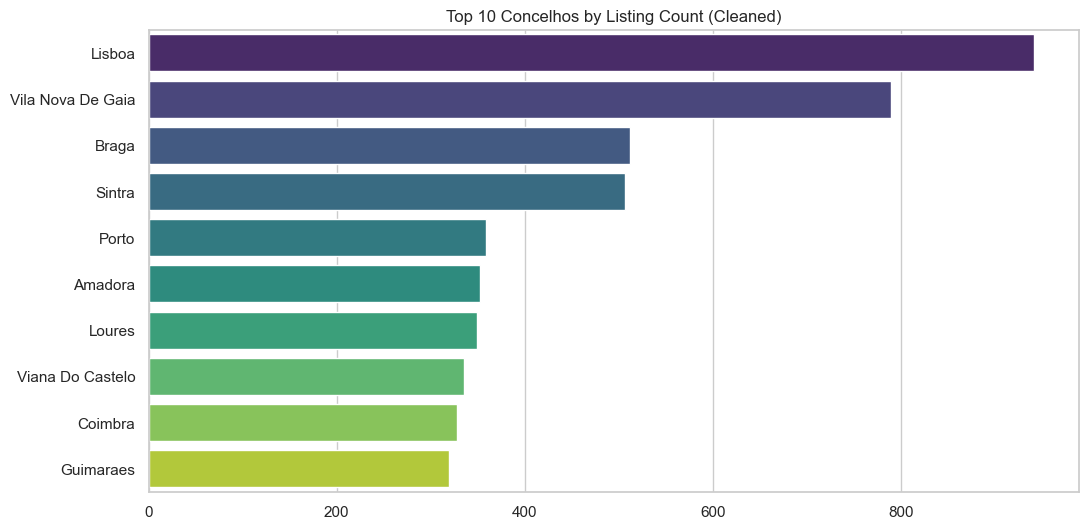

In [36]:
# Top 10 Concelhos by Volume
top_concelhos = df_clean['concelho'].value_counts().head(10)
sns.barplot(x=top_concelhos.values, y=top_concelhos.index, palette='viridis')
plt.title('Top 10 Concelhos by Listing Count (Cleaned)')
plt.show()

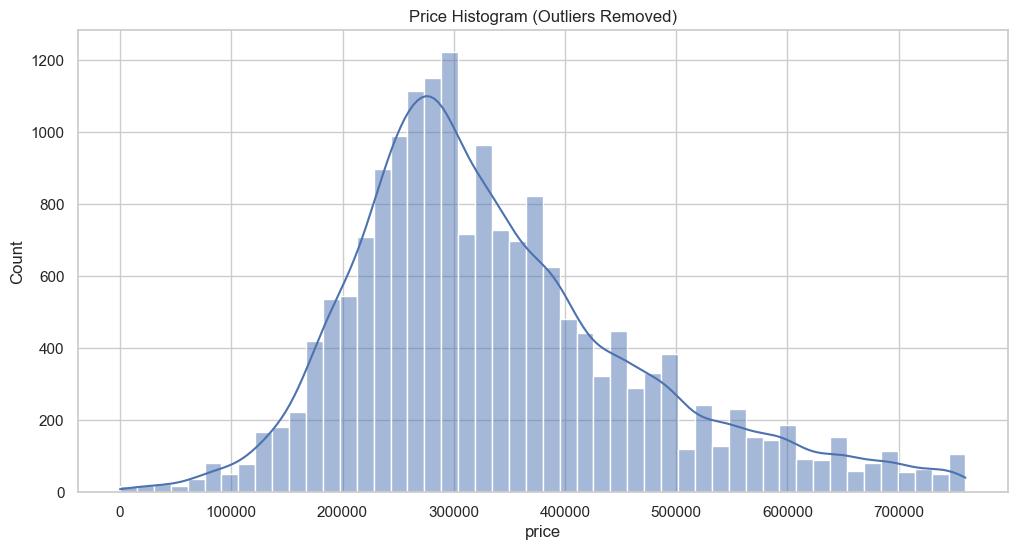

In [37]:
# Price Distribution
sns.histplot(df_clean['price'], bins=50, kde=True)
plt.title('Price Histogram (Outliers Removed)')
plt.show()

## 5. Feature vs. Target Analysis

Visualizing the core drivers of property price.

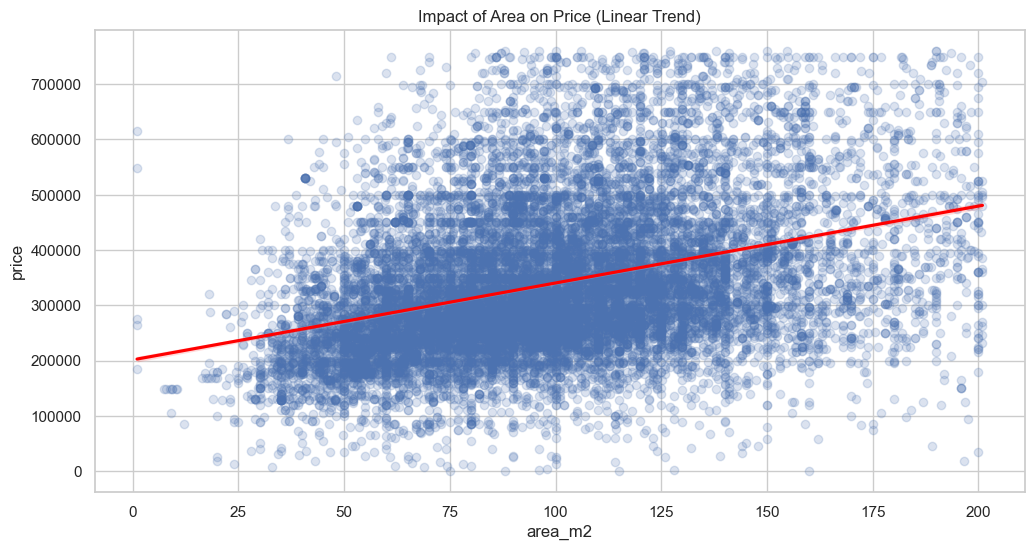

In [38]:
# Area vs Price with Regression Line
sns.regplot(data=df_clean, x='area_m2', y='price', scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Impact of Area on Price (Linear Trend)')
plt.show()

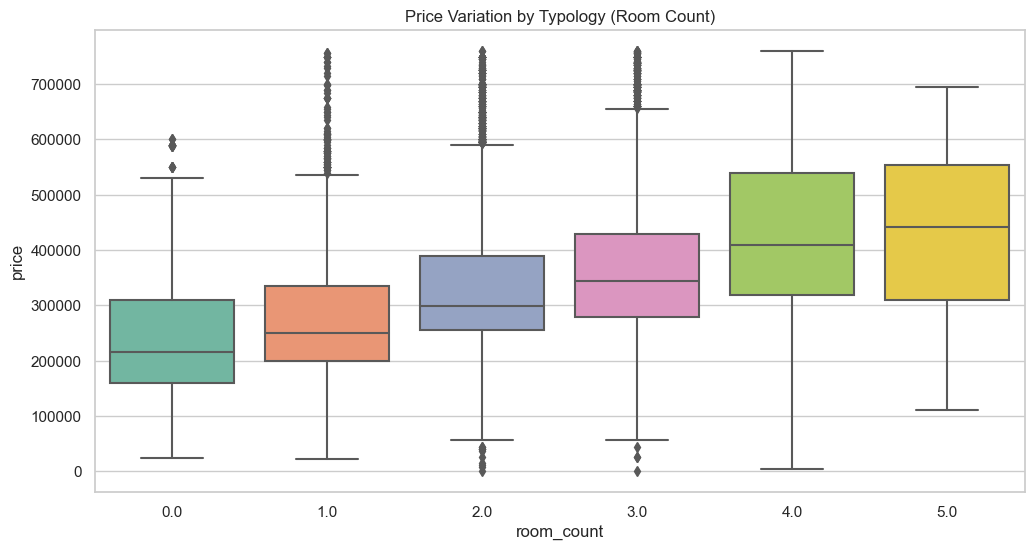

In [39]:
# Room Count vs Price
# Filter for T0-T5 to keep the plot readable
sns.boxplot(data=df_clean[df_clean['room_count'] <= 5], x='room_count', y='price', palette='Set2')
plt.title('Price Variation by Typology (Room Count)')
plt.show()

## 6. Geographic Deep Dive

Comparing regions by Price per m², which removes the impact of house size and reveals geographic value density.

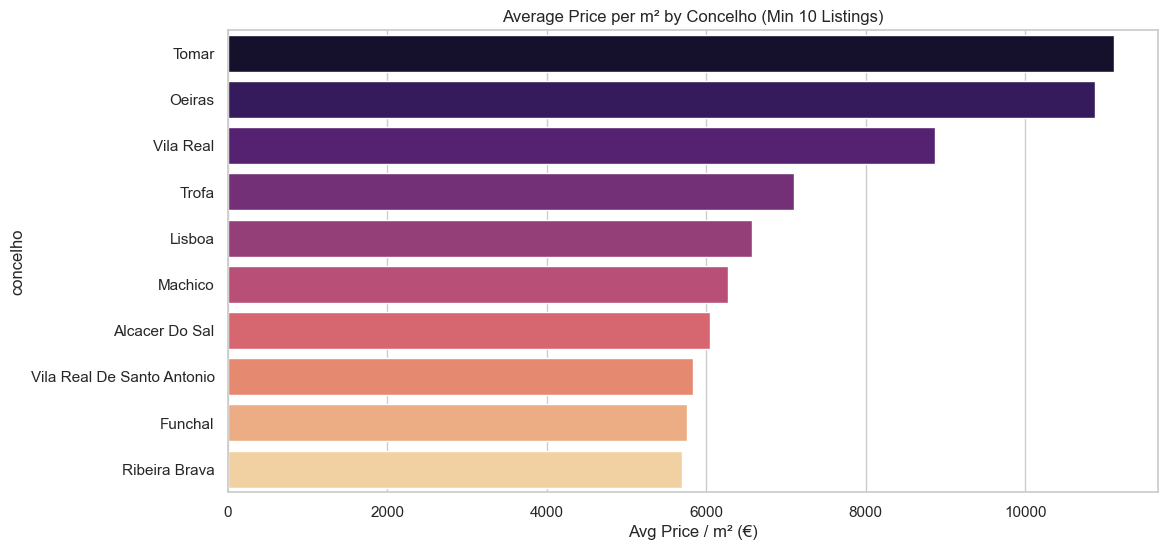

In [41]:
# Top 10 Concelhos by Avg Price per m2 (Minimum 10 listings)
# Aggregate mean and count simultaneously
concelho_stats = df_clean.groupby('concelho').agg({'price_per_m2': 'mean', 'title': 'count'})

# Filter for min 10 listings and SORT
geo_density = concelho_stats[concelho_stats['title'] >= 10]['price_per_m2'].sort_values(ascending=False).head(10)

sns.barplot(x=geo_density.values, y=geo_density.index, palette='magma')
plt.title('Average Price per m² by Concelho (Min 10 Listings)')
plt.xlabel('Avg Price / m² (€)')
plt.show()

## 7. Next Phase: Machine Learning Readiness

The data is now filtered and cleaned. Next steps:
1. Categorical Encoding (Label/One-Hot) for locations.
2. Training-Test split.
3. Running a Random Forest or XGBoost model to predict prices.